### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

### Import Datasets

In [2]:
# features
x_train = pd.read_csv('training_set.csv')
x_test = pd.read_csv('testing_set.csv')

# labels
y_train = pd.read_csv('training_labels.csv')
y_test = pd.read_csv('testing_labels.csv')

print(x_train.columns)
print(x_test.columns)
print(y_train.columns)
print(y_test.columns)

Index(['district', 'street', 'propertyType', 'remaining_lease', 'school',
       'hawkercentre', 'supermarkets', 'Bus Stops Nearby', 'crime_number',
       'latitude', 'longitude', 'floor_area_sqm', 'floor_range', 'sentiment'],
      dtype='object')
Index(['district', 'street', 'propertyType', 'remaining_lease', 'school',
       'hawkercentre', 'supermarkets', 'Bus Stops Nearby', 'crime_number',
       'latitude', 'longitude', 'floor_area_sqm', 'floor_range', 'sentiment'],
      dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')


In [3]:
x_train.head(2)

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_area_sqm,floor_range,sentiment
0,3,1664,6,78.75,24,16,7,0,193.285714,1.295995,103.803682,110.0,5,0.123678
1,18,1374,4,71.92,26,4,14,0,163.857143,1.373332,103.956317,122.0,1,0.077219


### Summary of Results
*Goal: Low RMSE, Low MAE, R2 close to 1, High Adjusted R2*, Low MAPE, Low SMAPE
    
Conclusions:
1. Random Forest better performance
2. For random forest, using Grid Search helped us in finding better estimators to improve the model slightly
3. For decision tree, using Grid Search did not help us to find better estimators (dk why? and the adjusted r2 for the model w grid search is negaative? huh? confused)

### Define function for MAPE and sMAPE

In [4]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)

### Decision Tree

#### (a) Basic Decision Tree with Default Parameters

[525800. 717200. 400000. ... 285000. 237000. 415000.]
training mse: 576926634.9985657, testing mse: 157018769457.6941
training rmse: 24019.297137896556, testing rmse: 396255.9393342819
training mae: 3730.394368578732, testing mae: 78205.02312426915
training R2: 0.999787644783206, testing R2: 0.9269542187103543
training adjusted R2: 0.9997876200714457, testing adjusted R2: 0.9268776393380274
training mape: 0.4807289647660674, testing mape: 6.400321560987108
training smape: 0.4787405746558657, testing smape: 6.290809701115248


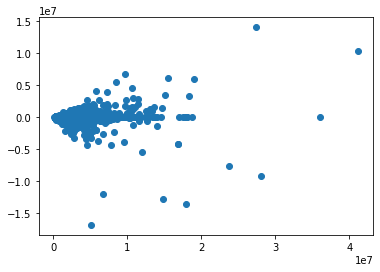

In [5]:
# train model
dt = tree.DecisionTreeRegressor()
dt.fit(x_train,y_train)

# make predictions on test set
y_pred_train = dt.predict(x_train)
y_pred = dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [6]:
dt.get_params(deep=True)

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

#### (b) Decision Tree using Best Estimators from Grid Search
- did 2 tests to kinda see which one better

In [7]:
# test 1: best parameter is 'max_leaf_nodes': [200,400,600,800], 'min_samples_split': [7,12,15,20]

In [8]:
params = {'max_features': [1,2,3,4,5], 'min_samples_split': [7,12,15,20,25]}
gsearch_dt = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), 
                          params, 
                          scoring = 'r2',
                          verbose=1, 
                          cv=3, 
                          n_jobs=-1)
gsearch_dt.fit(x_train, y_train)
print('best score:', gsearch_dt.best_score_)
print('best parameters: ', gsearch_dt.best_params_)
print('best estimators: ', gsearch_dt.best_estimator_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.2s finished


best score: 0.8848076321043811
best parameters:  {'max_features': 5, 'min_samples_split': 15}
best estimators:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=5,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')


[580000.         669740.66666667 394285.71428571 ... 275636.36363636
 245000.         369683.69230769]
training mse: 111459740548.75154, testing mse: 150395190674.12054
training rmse: 333855.8679261929, testing rmse: 387808.1879926216
training mae: 64336.10415905163, testing mae: 90505.83470321858
training R2: 0.9589738869170285, testing R2: 0.9300355349685996
training adjusted R2: 0.9589691127113932, testing adjusted R2: 0.9299621859712625
training mape: 4.621055130865226, testing mape: 6.384209075510773
training smape: 4.552921991034974, testing smape: 6.2550513574962245


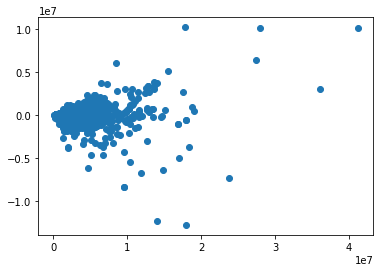

In [9]:
# make predictions on test set
y_pred_train = gsearch_dt.predict(x_train)
y_pred = gsearch_dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-gsearch_dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-gsearch_dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

# [350000. 368000. 370000. ... 443000. 700000. 330000.]
# training mse: 6.082366888803413e-24, testing mse: 157758759744.53165
# training rmse: 2.466245504568313e-12, testing rmse: 397188.5695038714
# training mae: 1.3061783434841964e-14, testing mae: 78282.53707872861
# training R2: 1.0, testing R2: 0.936556848348264
# training adjusted R2: 1.0, testing adjusted R2: 0.9312662771703689
# training mape: 4.610041212297163e-19, testing mape: 6.390628811775515
# training smape: 4.610041212297164e-19, testing smape: 6.320467211747645

In [10]:
# test 2: best parameter is 'min_samples_split': [7,12,15,20,25]

In [11]:
params = {'min_samples_split': [7,12,15,20,25]}
gsearch_dt = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), 
                          params, 
                          scoring = 'r2',
                          verbose=1, 
                          cv=3, 
                          n_jobs=-1)
gsearch_dt.fit(x_train, y_train)
print('best score:', gsearch_dt.best_score_)
print('best parameters: ', gsearch_dt.best_params_)
print('best estimators: ', gsearch_dt.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.2s finished


best score: 0.8843238543949316
best parameters:  {'min_samples_split': 25}
best estimators:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')


[522440.         707111.11111111 386250.         ... 278863.63636364
 261309.89473684 388111.        ]
training mse: 103237466407.11078, testing mse: 155023130145.71698
training rmse: 321305.8767080222, testing rmse: 393729.7679192126
training mae: 63510.774434985295, testing mae: 88434.93175152308
training R2: 0.9620003424522143, testing R2: 0.9278825983761686
training adjusted R2: 0.9619959204349777, testing adjusted R2: 0.9278069922938911
training mape: 4.64983042955152, testing mape: 6.2053590719897445
training smape: 4.592870813856349, testing smape: 6.080733301088615


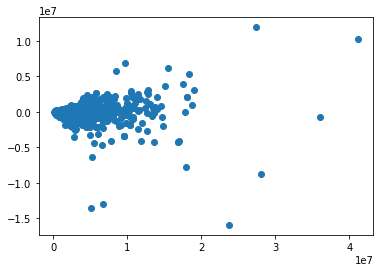

In [12]:
# make predictions on test set
y_pred_train = gsearch_dt.predict(x_train)
y_pred = gsearch_dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-gsearch_dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-gsearch_dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

### Random Forest

#### (a) Basic Random Forest with Default Parameters

/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[516266.66666667 759188.8        396000.         ... 282500.
 251883.33333333 403000.        ]
training mse: 29326278567.769978, testing mse: 86170624192.17369
training rmse: 171249.17099878172, testing rmse: 293548.3336559308
training mae: 29870.167080575888, testing mae: 69585.87206181465
training R2: 0.989205580284858, testing R2: 0.9599130690549089
training adjusted R2: 0.9892043241390631, testing adjusted R2: 0.9598710429179289
training mape: 2.3492615811121107, testing mape: 5.501983168252391
training smape: 2.31609696415493, testing smape: 5.363945322921274


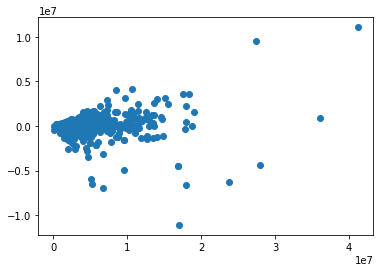

In [13]:
# train model
rforest = ensemble.RandomForestRegressor()
rforest.fit(x_train,y_train)

# make predictions on test set
y_pred_train = rforest.predict(x_train)
y_pred = rforest.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-rforest.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-rforest.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [14]:
rforest.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### (b) Random Forest using Best Estimators from Grid Search
- did 2 tests to kinda see which one better

In [15]:
# test 1: best parameter is 150

In [ ]:
params = {'n_estimators': [10,50,100,150]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'r2', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [ ]:
# test 2: best parameter is 150

In [ ]:
params = {'n_estimators': [100,150,200,250]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'r2', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

In [ ]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [ ]:
params = {'n_estimators': [10]}
grid_search_cv = GridSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'r2', 
                              verbose=1, 
                              cv=3,
                              n_jobs = -1)
grid_search_cv.fit(x_train, y_train)
print('best score:', grid_search_cv.best_score_)
print('best parameters: ', grid_search_cv.best_params_)
print('best estimators: ', grid_search_cv.best_estimator_)

In [ ]:
# make predictions on test set
y_pred_train = grid_search_cv.predict(x_train)
y_pred = grid_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-grid_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-grid_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training R2: {}, testing R2: {}".format(dt.score(x_train, y_train), dt.score(x_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
x_axis = y_test.squeeze() # fitted value
y_axis = y_test.squeeze()- y_pred.squeeze() # residual
plt.scatter(x_axis,y_axis) 

In [ ]:
rforest.get_params(deep=True)